In [1]:
#Importing the necessary libraries

import os 
import sys
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np

import statsmodels.api as sm


In [2]:
#Global Settings 
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [3]:
#Importing Configs
# Define the path where config.py is located
#Mac
os.chdir('/Users/kylenabors/Documents/GitHub/Finance-ML-Modeling')
config_file_path = os.getcwd()
print(config_file_path)

# Add this path to the sys.path
sys.path.append(config_file_path)

import config

#Configs
finbert_models = config.finbert_models
Body = config.Body
database = config.Local_Database

/Users/kylenabors/Documents/GitHub/Finance-ML-Modeling
/Users/kylenabors/Documents/GitHub/Finance-ML-Modeling
/Users/kylenabors/Documents
/Users/kylenabors/Documents/GitHub/Finance-ML-Modeling


In [4]:
sentiment = pd.date_range(start='1/1/1990', end='1/1/2024', freq='D')
sentiment = pd.DataFrame(sentiment, columns=['date'])

Body = 'Fed'

state = pd.read_csv(f"{finbert_models}/{Body}/Statements/{Body}_Statements_finbert_model_short.csv")
state = state[['date','sentiment']]
state = state.rename(columns={'sentiment':'statement_sentiment'})
state['date'] = pd.to_datetime(state['date'])
sentiment = pd.merge(sentiment, state, how='left', left_on='date', right_on='date')

minutes = pd.read_csv(f"{finbert_models}/{Body}/Minutes/{Body}_Minutes_finbert_model_short.csv")
minutes = minutes[['date','sentiment']]
minutes = minutes.rename(columns={'sentiment':'minute_sentiment'})
minutes['date'] = pd.to_datetime(minutes['date'])
sentiment = pd.merge(sentiment, minutes, how='left', left_on='date', right_on='date')


Body = 'ECB'
mpd = pd.read_csv(f"{finbert_models}/{Body}/Monetary policy decisions/{Body}_Monetary policy decisions_finbert_model_short.csv")
mpd = mpd[['date','sentiment']]
mpd = mpd.rename(columns={'sentiment':'mpd_sentiment'})

mpd['date'] = pd.to_datetime(mpd['date'])

sentiment = pd.merge(sentiment, mpd, how='left', left_on='date', right_on='date')




In [5]:
sentiment = sentiment.groupby(pd.Grouper(key='date', freq='D')).mean().reset_index()

In [6]:
mpd = mpd.groupby('date').mean().reset_index()
mpd['count'] = range(len(mpd))
mpd = mpd[['date','count']]
sentiment = pd.merge(sentiment, mpd, how='left', left_on='date', right_on='date')
sentiment['count'] = sentiment['count'].ffill()


In [7]:
mich = pd.read_csv(f'{database}/Market Data/Michigan/michigan_sent.csv')
#convert Month from a string to a number
mich['Month'] = mich['Month'].str.replace('January', '01')
mich['Month'] = mich['Month'].str.replace('February', '02')
mich['Month'] = mich['Month'].str.replace('March', '03')
mich['Month'] = mich['Month'].str.replace('April', '04')
mich['Month'] = mich['Month'].str.replace('May', '05')
mich['Month'] = mich['Month'].str.replace('June', '06')
mich['Month'] = mich['Month'].str.replace('July', '07')
mich['Month'] = mich['Month'].str.replace('August', '08')
mich['Month'] = mich['Month'].str.replace('September', '09')
mich['Month'] = mich['Month'].str.replace('October', '10')
mich['Month'] = mich['Month'].str.replace('November', '11')
mich['Month'] = mich['Month'].str.replace('December', '12')
    
#combine Month and YYYY columns and convert to datetime
mich['date'] = mich['Month'].astype(str) + '-' + mich['YYYY'].astype(str)
mich['date'] = pd.to_datetime(mich['date'])
mich = mich[['date', 'ICS_ALL']]
mich = mich.rename(columns={'ICS_ALL':'michigan_sentiment'})

sentiment = pd.merge(sentiment, mich, how='outer', left_on='date', right_on='date')

/var/folders/9h/v8gnzwrs73v52x4lyzz2z2zc0000gn/T/ipykernel_45123/3042254654.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  mich['date'] = pd.to_datetime(mich['date'])


In [8]:
market =pd.read_csv(f'{database}/Market Data/All Market Data.csv')
market = market.rename(columns={'PCE':'pce', 'GDP':'gdp', 'GDPPOT':'gdp_pot'})
market['date'] = pd.to_datetime(market['date'])


In [9]:
taylor = pd.read_csv(f'/Users/kylenabors/Documents/Database/Market Data/Taylor/Taylor.csv')
taylor['date'] = pd.to_datetime(taylor['date'])
taylor = taylor.rename(columns={'Taylor':'taylor_fred'})

In [10]:
sentiment = pd.merge(sentiment, market, how='left', left_on='date', right_on='date')
#sentiment = pd.merge(sentiment, taylor, how='left', left_on='date', right_on='date'

In [11]:
sentiment = sentiment[(sentiment['date'] >= '2000-01-01') & (sentiment['date'] <= '2023-06-30')]

temp = sentiment.copy(deep=True)
temp = temp[['count', 'stoxx']]
temp['log_returns'] = np.log(temp['stoxx'] + 1)
temp = temp[['count', 'log_returns']]
temp = temp.groupby('count').sum().reset_index()
sentiment = sentiment.groupby(sentiment['count']).mean().reset_index()
sentiment = pd.merge(sentiment, temp, how='left', left_on='count', right_on='count')

sentiment = sentiment.drop(columns=['date'])
mpd = mpd[['date','count']]
sentiment = pd.merge(sentiment, mpd, how='left', left_on='count', right_on='count')
sentiment['date'] = pd.to_datetime(sentiment['date'])
sentiment['mpd_sentiment_diff'] = sentiment['mpd_sentiment'].diff()


In [12]:
filter_items = ['mpd_sentiment', 'mpd_sentiment_diff', 'log_returns']

for item in filter_items:
    filter_df = sentiment.copy(deep=True)
    filter_df = filter_df[['date', f'{item}']]
    
    #cycle, trend = sm.tsa.filters.hpfilter(filter_df[f'{item}'], 1600)
    cycle, trend = sm.tsa.filters.hpfilter(filter_df[f'{item}'], (100*(8**2)))

    item_decomp = filter_df[[f'{item}']]
    item_decomp[f"{item}_cycle"] = cycle
    item_decomp[f"{item}_trend"] = trend

    filter_df = pd.merge(filter_df, item_decomp, on=f'{item}', how='left')  

    filter_df = filter_df[['date', f'{item}_cycle', f'{item}_trend']]
    filter_df = filter_df.groupby('date').mean().reset_index()

    sentiment = pd.merge(sentiment, filter_df, on='date', how='left')

In [13]:
sentiment['mpd_sentiment_diff2'] = sentiment['mpd_sentiment_cycle'].diff()

In [14]:
sentiment['michigan_sentiment_norm'] = (sentiment['michigan_sentiment'] - sentiment['michigan_sentiment'].mean()) / (sentiment['michigan_sentiment'].max() - sentiment['michigan_sentiment'].min())
sentiment['mpd_sentiment_norm'] = (sentiment['mpd_sentiment'] - sentiment['mpd_sentiment'].mean()) / (sentiment['mpd_sentiment'].max() - sentiment['mpd_sentiment'].min())

#Createa a new column that is a dummy variable for minute sentiment being greater than michigan sentiment
sentiment['mpd_sentiment_dummy'] = np.where(sentiment['mpd_sentiment_norm'] > sentiment['mpd_sentiment_norm'].shift(-1), 1, 0)

In [15]:
sentiment['gap'] = (sentiment['gdp'] - sentiment['gdp_pot'])/sentiment['gdp_pot']
sentiment['gap'] = sentiment['gap']*100

In [16]:
sentiment['taylor'] = 2 + sentiment['gdpdef'] + 0.5*(sentiment['gdpdef'] - 2) + 0.5*(sentiment['gap'])

In [17]:
#caculate moving average of minute sentiment
rolling = 8
sentiment['mpd_sentiment_rolling'] = sentiment['mpd_sentiment'].rolling(window=rolling).mean()
sentiment['log_returns_rolling'] = sentiment['log_returns'].rolling(window=rolling).mean()
sentiment['michigan_sentiment_rolling'] = sentiment['michigan_sentiment'].rolling(window=rolling).mean()
sentiment['mpd_sentiment_diff_rolling'] = sentiment['mpd_sentiment_diff'].rolling(window=rolling).mean()


In [18]:
sentiment_groups = [ 'mpd_sentiment', 'mpd_sentiment_diff2', 'mpd_sentiment_cycle',
                    'mpd_sentiment_rolling', 'mpd_sentiment_diff', 'mpd_sentiment_diff_rolling',
                    'log_returns', 'log_returns_rolling'
                    ]
for group in sentiment_groups:
    for i in range(0, 6):
        sentiment[f'{group}_{i}'] = sentiment[f'{group}'].shift(i)
        #sentiment[f'{group}_{i}'] =  sentiment[f'{group}_{i}'].diff()
        #sentiment[f'{group}_sentiment_forward_{i}'] = sentiment[f'{group}_sentiment'].shift(-i)
        
market_groups = ['euro_funds']

for group in market_groups:
    for i in range(0, 5):
        sentiment[f'{group}_{i}'] = sentiment[f'{group}'].shift(i)
        #sentiment[f'{group}_forward_{i}'] = sentiment[f'{group}'].shift(-i)

In [19]:
sentiment = sentiment[(sentiment['date'] >= '2000-01-01') & (sentiment['date'] <= '2023-06-30')]
sentiment.to_csv(f'/Users/kylenabors/Documents/Database/Models/FinBERT Models/taylor MBreak Euro.csv', index=False)

In [20]:
# #create a list of all the columns in the dataframe sentiment
# columns = sentiment.columns


# #loop through the columns and normalize the data
# for column in columns:
#     if column != 'date':
#         sentiment[column] = (sentiment[column] - sentiment[column].mean()) / (sentiment[column].max() - sentiment[column].min())

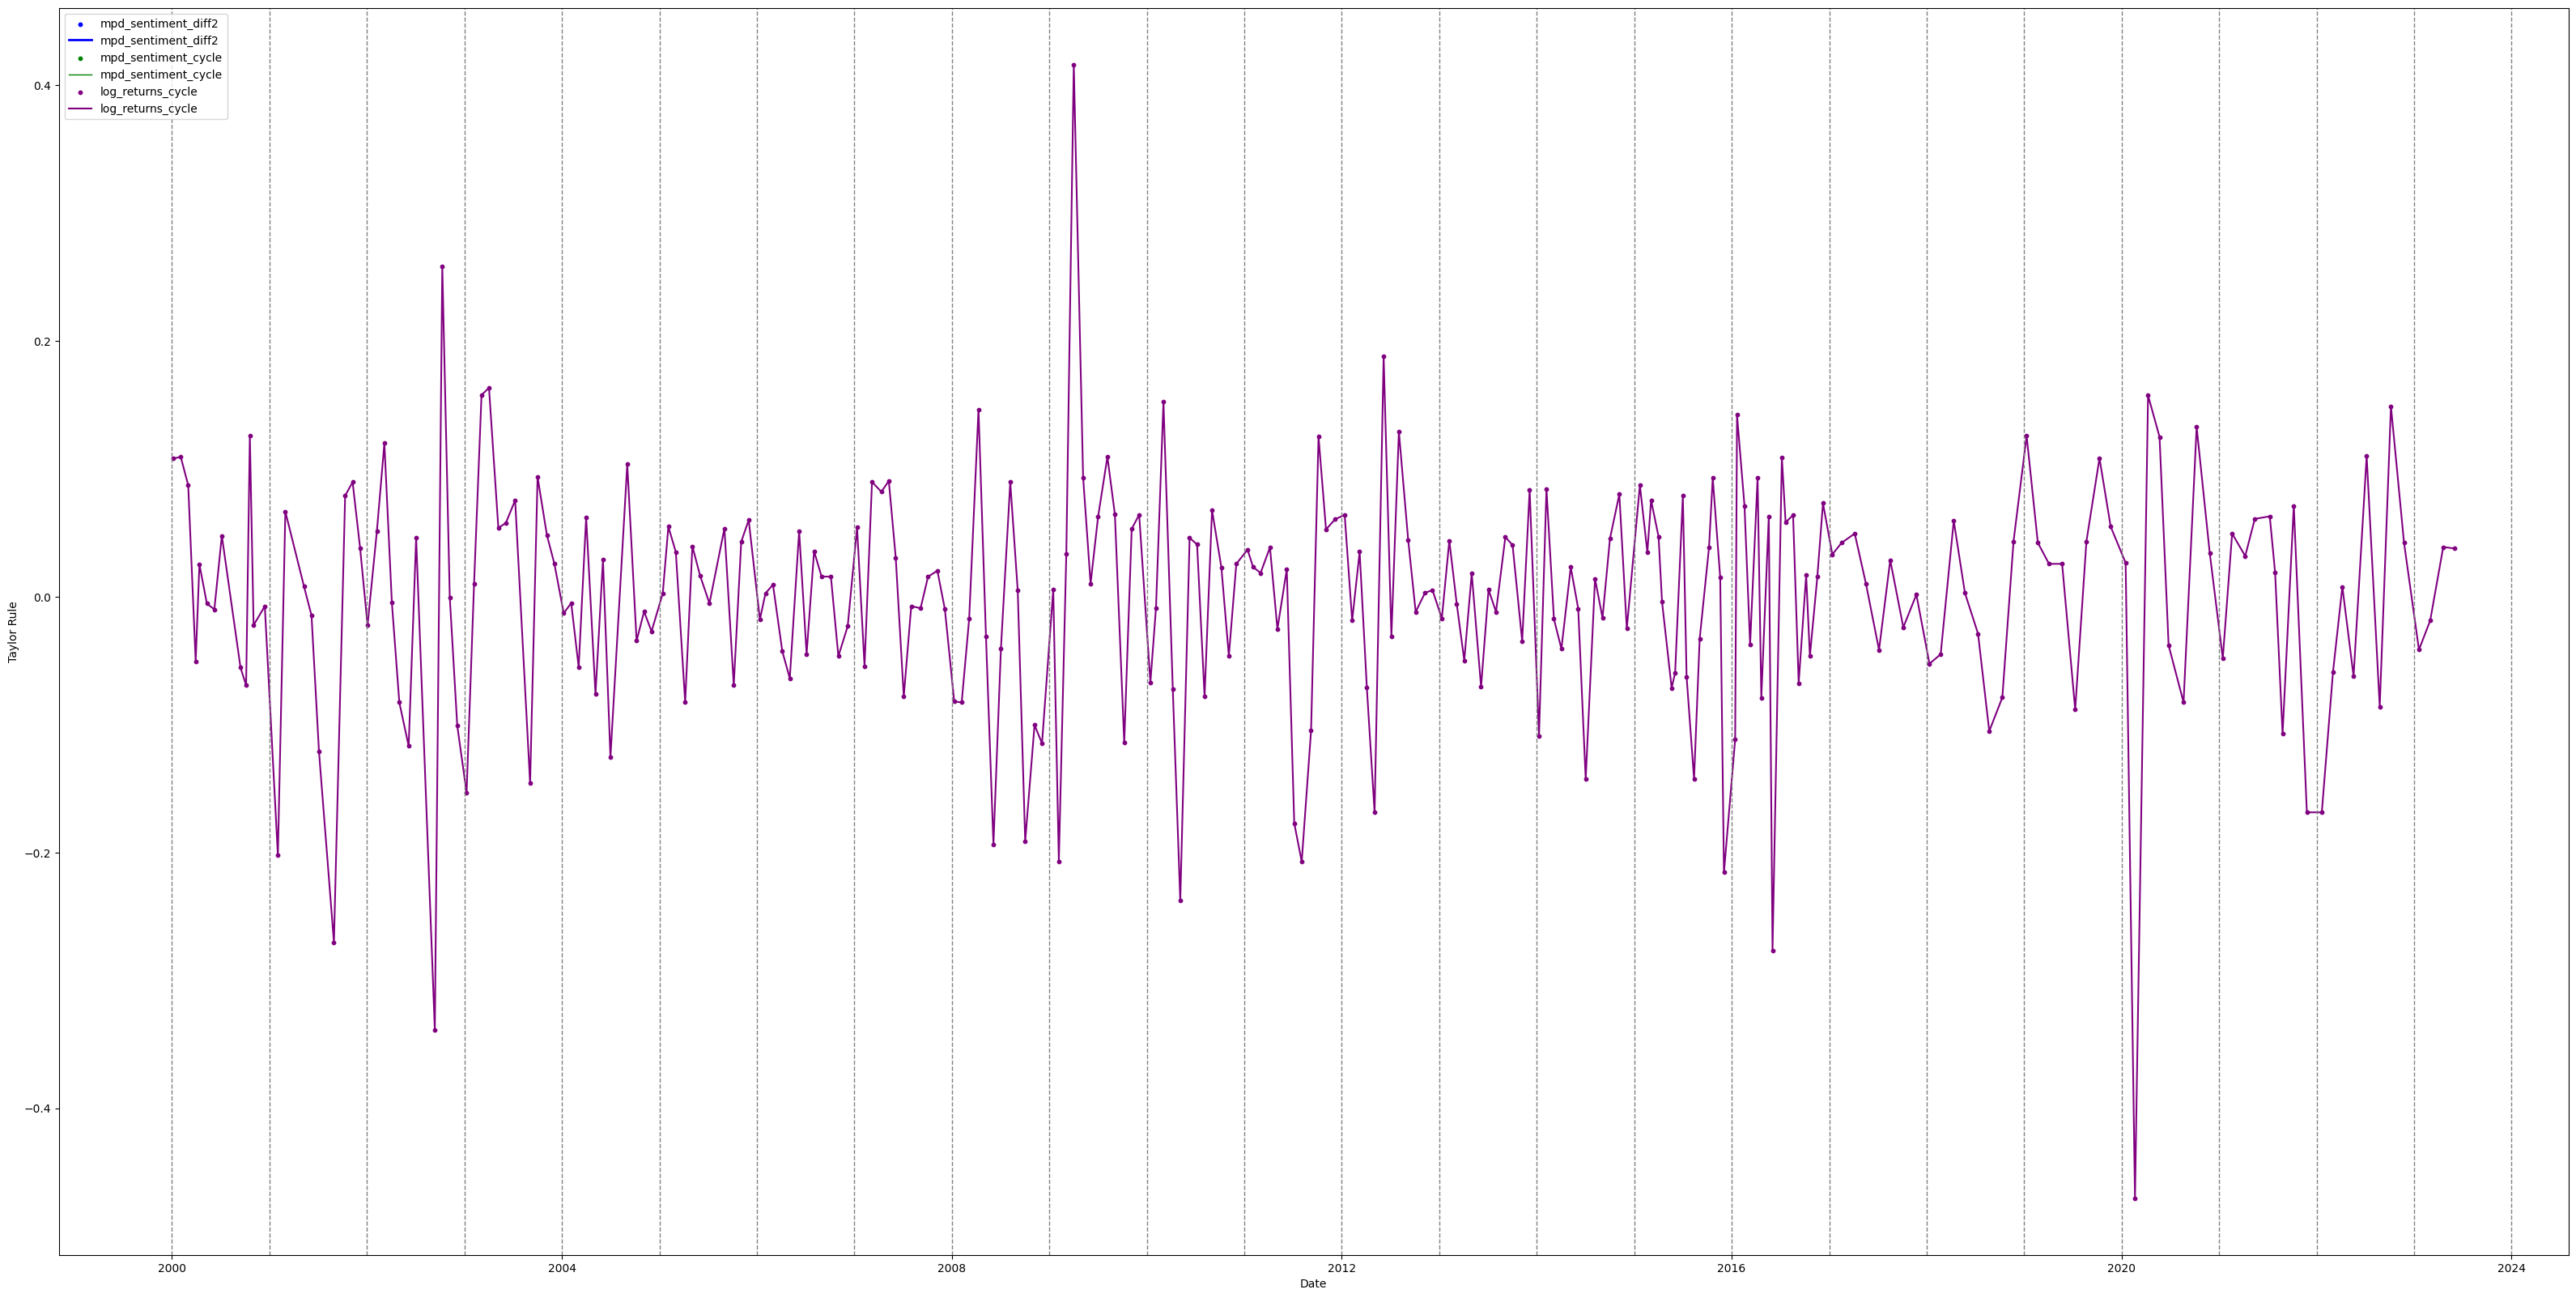

In [21]:
x1 = 'mpd_sentiment_diff2'
x2 = 'mpd_sentiment_cycle'
x3 = 'log_returns'
x4 = 'log_returns_cycle'

#Graph the Data
fig, ax = plt.subplots(figsize = (40, 20))

ax.scatter(sentiment['date'], sentiment[f'{x1}'], label=f'{x1}', color='blue', s=10)
ax.plot(sentiment['date'], sentiment[f'{x1}'], label=f'{x1}', color='blue', lw=2)

ax.scatter(sentiment['date'], sentiment[f'{x2}'], label=f'{x2}', color='green', s=10)
ax.plot(sentiment['date'], sentiment[f'{x2}'], label=f'{x2}', color='green', lw=1)

# ax.scatter(sentiment['date'], sentiment[f'{x3}'], label=f'{x3}', color='red', s=10)
# ax.plot(sentiment['date'], sentiment[f'{x3}'], label=f'{x3}', color='red', lw = 2)

ax.scatter(sentiment['date'], sentiment[f'{x4}'], label=f'{x4}', color='purple', s=10)
ax.plot(sentiment['date'], sentiment[f'{x4}'], label=f'{x4}', color='purple')

# ax.scatter(sentiment['date'], sentiment['taylor'], label='Taylor Rule', color='black', s=10)
# ax.plot(sentiment['date'], sentiment['taylor'], label='Taylor Rule', color='grey')

# ax.scatter(sentiment['date'], sentiment['taylor_euro'], label='Taylor Rule Europe', color='black', s=10)
# ax.plot(sentiment['date'], sentiment['taylor_euro'], label='Taylor Rule Europe', color='grey')

#Create a vertical line at every year 
for year in range(2000, 2025):
    ax.axvline(pd.to_datetime(f'{year}-01-01'), color='gray', linestyle='--', lw=1)

ax.set_xlabel('Date')
ax.set_ylabel('Taylor Rule')
ax.legend()
plt.show()


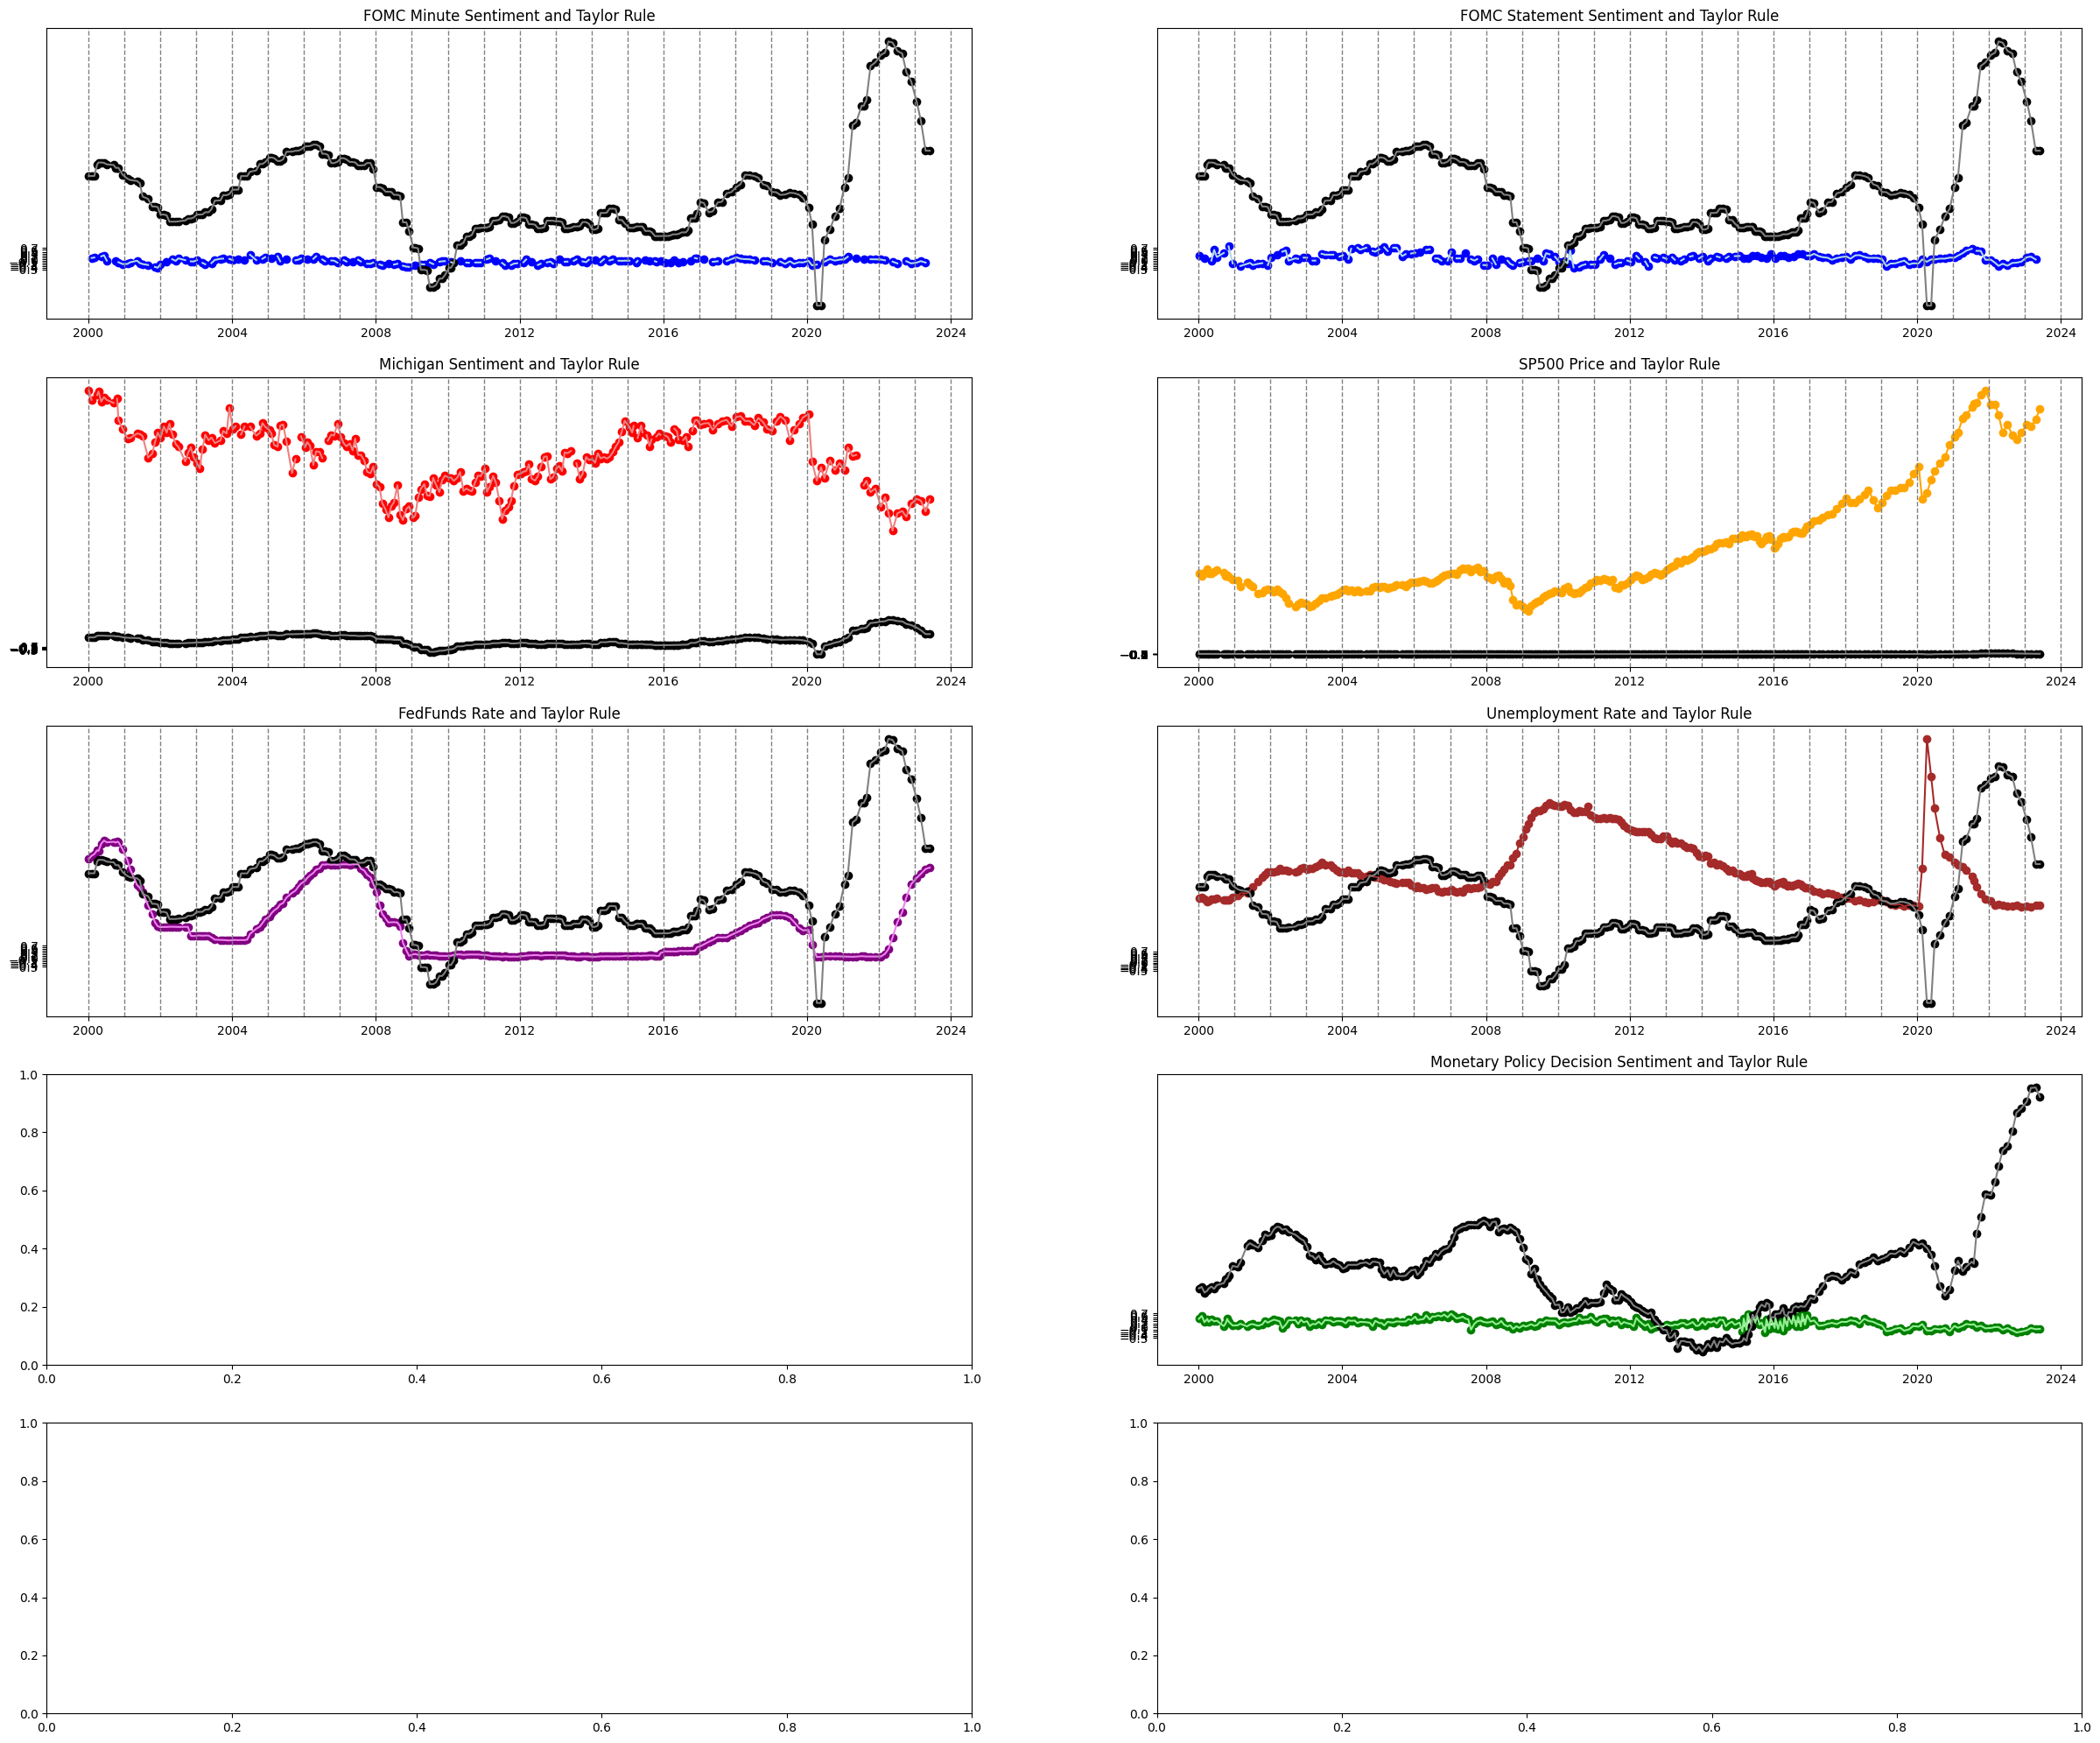

In [22]:
#recreate the previous graph but using multiple subplots where every subplot is a different variable compared to the Taylor Rule
fig, ax = plt.subplots(5, 2, figsize = (30, 25))

ax[0, 0].scatter(sentiment['date'], sentiment['minute_sentiment'], label='FOMC Minute Sentiment', color='blue')
ax[0, 0].plot(sentiment['date'], sentiment['minute_sentiment'], label='FOMC Minute Sentiment', color='lightblue')
ax[0, 0].scatter(sentiment['date'], sentiment['taylor'], label='Taylor Rule', color='black')
ax[0, 0].plot(sentiment['date'], sentiment['taylor'], label='Taylor Rule', color='grey')
ax[0, 0].set_title('FOMC Minute Sentiment and Taylor Rule')
ax[0, 0].set_yticks(np.arange(-0.5, 0.8, 0.1))

ax[0, 1].scatter(sentiment['date'], sentiment['statement_sentiment'], label='Statement Sentiment', color='blue')
ax[0, 1].plot(sentiment['date'], sentiment['statement_sentiment'], label='Statement Sentiment', color='lightblue')
ax[0, 1].scatter(sentiment['date'], sentiment['taylor'], label='Taylor Rule', color='black')
ax[0, 1].plot(sentiment['date'], sentiment['taylor'], label='Taylor Rule', color='grey')
ax[0, 1].set_title('FOMC Statement Sentiment and Taylor Rule')
ax[0, 1].set_yticks(np.arange(-0.5, 0.8, 0.1))

ax[1, 0].scatter(sentiment['date'], sentiment['michigan_sentiment'], label='Michigan Sentiment', color='red')
ax[1, 0].plot(sentiment['date'], sentiment['michigan_sentiment'], label='Michigan Sentiment', color='lightcoral')
ax[1, 0].scatter(sentiment['date'], sentiment['taylor'], label='Taylor Rule', color='black')
ax[1, 0].plot(sentiment['date'], sentiment['taylor'], label='Taylor Rule', color='grey')
ax[1, 0].set_title('Michigan Sentiment and Taylor Rule')
ax[1, 0].set_yticks(np.arange(-0.5, 0.8, 0.1))

ax[1, 1].scatter(sentiment['date'], sentiment['sp500_price'], label='SP500 Price', color='orange')
ax[1, 1].plot(sentiment['date'], sentiment['sp500_price'], label='SP500 Price', color='orange')
ax[1, 1].scatter(sentiment['date'], sentiment['taylor'], label='Taylor Rule', color='black')
ax[1, 1].plot(sentiment['date'], sentiment['taylor'], label='Taylor Rule', color='grey')
ax[1, 1].set_title('SP500 Price and Taylor Rule')
ax[1, 1].set_yticks(np.arange(-0.5, 0.8, 0.1))

ax[2, 0].scatter(sentiment['date'], sentiment['fedfunds'], label='FedFunds Rate', color='purple')
ax[2, 0].plot(sentiment['date'], sentiment['fedfunds'], label='FedFunds Rate', color='violet')
ax[2, 0].scatter(sentiment['date'], sentiment['taylor'], label='Taylor Rule', color='black')
ax[2, 0].plot(sentiment['date'], sentiment['taylor'], label='Taylor Rule', color='grey')
ax[2, 0].set_title('FedFunds Rate and Taylor Rule')
ax[2, 0].set_yticks(np.arange(-0.5, 0.8, 0.1))

ax[2, 1].scatter(sentiment['date'], sentiment['unemployment'], label='Unemployment Rate', color='brown')
ax[2, 1].plot(sentiment['date'], sentiment['unemployment'], label='Unemployment Rate', color='brown')
ax[2, 1].scatter(sentiment['date'], sentiment['taylor'], label='Taylor Rule', color='black')
ax[2, 1].plot(sentiment['date'], sentiment['taylor'], label='Taylor Rule', color='grey')
ax[2, 1].set_title('Unemployment Rate and Taylor Rule')
ax[2, 1].set_yticks(np.arange(-0.5, 0.8, 0.1))



ax[3, 1].scatter(sentiment['date'], sentiment['mpd_sentiment'], label='Monetary Policy Decision Sentiment', color='green')
ax[3, 1].plot(sentiment['date'], sentiment['mpd_sentiment'], label='Monetary Policy Decision Sentiment', color='lightgreen')
ax[3, 1].scatter(sentiment['date'], sentiment['taylor_euro'], label='Taylor Rule Europe', color='black')
ax[3, 1].plot(sentiment['date'], sentiment['taylor_euro'], label='Taylor Rule Europe', color='grey')
ax[3, 1].set_title('Monetary Policy Decision Sentiment and Taylor Rule')
ax[3, 1].set_yticks(np.arange(-0.5, 0.8, 0.1))


#Create a vertical line at every year
for i in range(3):
    for j in range(2):
        for year in range(2000, 2025):
            ax[i, j].axvline(pd.to_datetime(f'{year}-01-01'), color='gray', linestyle='--', lw=1)
            
plt.show()